In [1]:
using Turing
using StatsPlots
using Optim

In [2]:
PRINT_PROGRESS = true
include("read_data.jl")
include("utils.jl")

# Iterative Bayesian Modeling with Probabilistic Programming

- ## Time Series Model
- ## Trend
- ## Seasonality
- ## Debugging
- ## Combine + Forecast
- ## Bonus

### Dataset: World-Wide Monthly Air Passengers

Data source: https://www.transtats.bts.gov/Data_Elements.aspx

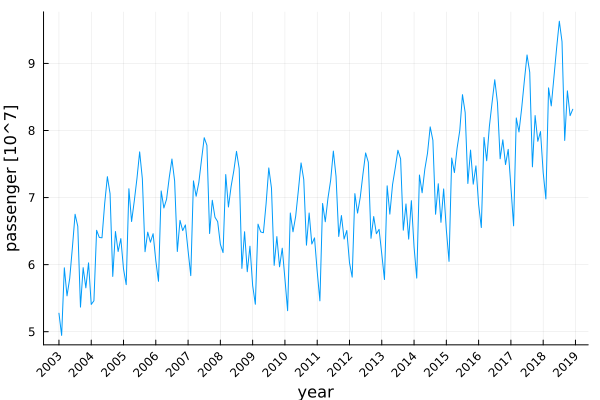

In [3]:
base_plot(air_passengers_2013_2018)

### First Start: A Linear Trend Model

We start easy by modelling the trend of the time series.

A Bayesian linear regression is the "hello world" example for probabilistic programs and can be used to model linear trends.

We focus on the part of the time series which approximately exhibits a linear trend.

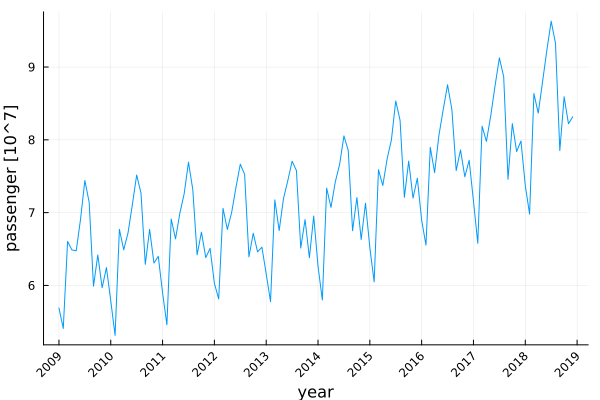

In [4]:
upwards_trend_data = air_passengers_2013_2018[2009 .<= air_passengers_2013_2018[!,"Year"],:]
base_plot(upwards_trend_data)

In [5]:
@model function trend_model_1(x::Vector{Float64}, y::Vector{Float64})
    # priors are chosen to be very broad
    # (we do not want to favour any specific values)
    slope ~ Normal(0,3)
    intercept ~ Normal(6,3)
    # error models how noisy the data is, it has to be >0 => InverseGamma
    error ~ InverseGamma(2,3)
    
    for i in eachindex(y)
        # shift the x-axis by start year 0...16 instead of 2003...2019
        y[i] ~ Normal(slope * (x[i] - x[1]) + intercept, error+1e-5)
    end
end

trend_model_1 (generic function with 2 methods)

If the model allows it (continuous density), the inference algorithm `NUTS` is always a good first choice.

In [6]:
Turing.Random.seed!(0)
res_1 = sample(trend_model_1(upwards_trend_data[!,"Date"], upwards_trend_data[!,"Total"]), NUTS(), 3000, progress=PRINT_PROGRESS)
res_1

┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (3000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 5.93 seconds
Compute duration  = 5.93 seconds
parameters        = slope, intercept, error
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       slope    0.2259    0.0211    0.0006   1331.8484   1136.0243    1.0019   ⋯
   intercept    6.0915    0.1220    0.0034   1333.0084   1250.1463    1.0024   ⋯
       error    0.6400    0.0429    0.0010   1975.4241   1731.1088    0.9997   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50

While we can inspect the summary statistics above, plotting the results gives a quick and easy check if everything works as expected.

To start, we plot the maximum-a-posteriori (MAP) estimate - the most likely values for the latent variables under the posterior.

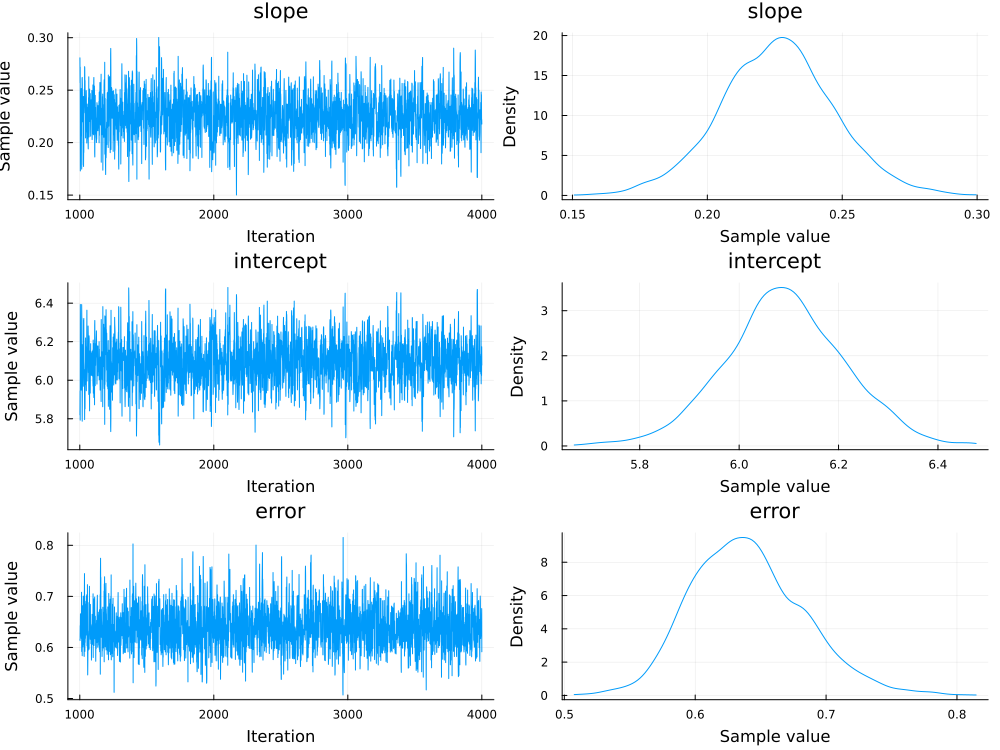

In [7]:
plot(res_1)

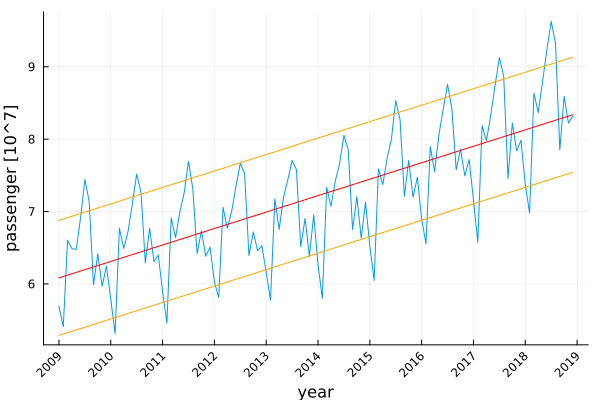

In [8]:
_, map_vector = get_map(res_1)
plot_trend_model_1_map(upwards_trend_data, map_vector)

But of course as Bayesian statisticians we also care about the uncertainty around our estimates.

So we plot samples from the posterior.

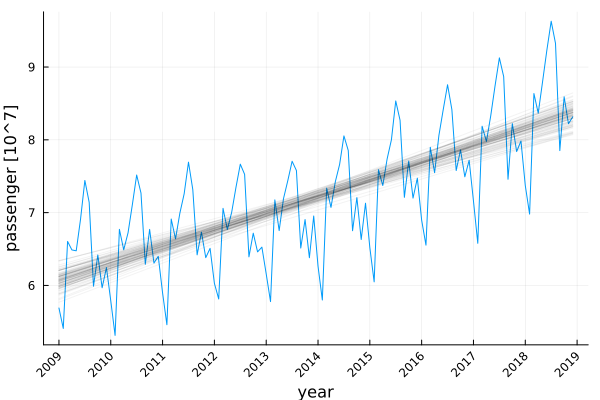

In [9]:
plot_trend_model_1_posterior(upwards_trend_data, res_1[1:30:end])

### Changing Trend

From the plot above we can see that a linear model does not perfectly describe the trend in the time series.

In particular, after 2014 there seems to be a steeper increase in passengers then before.

Lets see if we can model this with a changepoint.

In [10]:
@model function trend_model_2(x::Vector{Float64}, y::Vector{Float64})
    slope ~ Normal(0,3)
    intercept ~ Normal(6,3)
    error ~ InverseGamma(2,3)

    # UPGRADE: sample changepoint and adjustment to be made at changepoint
    changepoint ~ Uniform(0, x[end] - x[1])
    adjustment ~ Normal(0,1)

    for i in eachindex(y)
        t = x[i] - x[1]
        k = slope
        m = intercept
        # UPGRADE: if the time series exceeds the changepoint, we adjust slope and intercept in a continuous way
        if changepoint ≤ t
            k += adjustment
            m -= changepoint * adjustment
        end
        
        y[i] ~ Normal(k * t + m, error+1e-5)
    end
end

trend_model_2 (generic function with 2 methods)

In [11]:
Turing.Random.seed!(0)
res_2 = sample(trend_model_2(upwards_trend_data[!,"Date"], upwards_trend_data[!,"Total"]), NUTS(), 3000, progress=PRINT_PROGRESS);

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Again, plotting is our best friend.

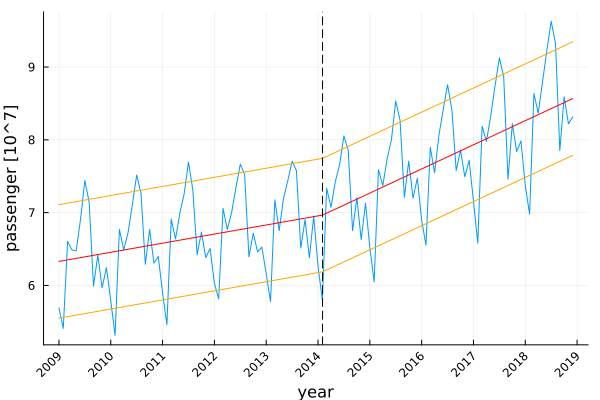

In [12]:
_, map_vector = get_map(res_2)
single_chainpoint_res = res_2
plot_trend_model_2(upwards_trend_data, map_vector)

### Multiple Changepoints

If we turn our attention back to the full time series, we can see that there seem to be multiple changes in the trend.

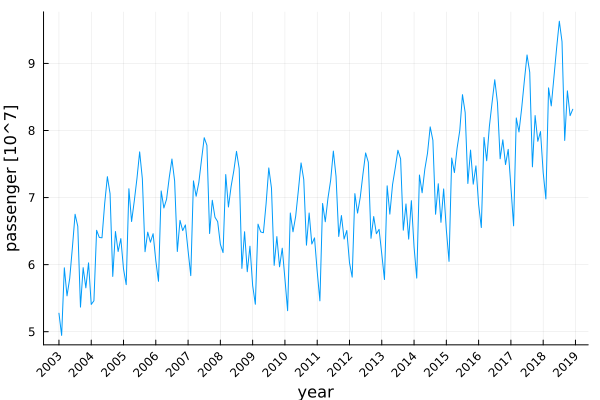

In [13]:
base_plot(air_passengers_2013_2018)

Let's see if we can simply modify our model to handle multiple changepoints.

In [14]:
@model function trend_model_3_1(x::Vector{Float64}, y)
    slope ~ Normal(0,1)
    intercept ~ Normal(6,1)
    error ~ InverseGamma(2,3)
    
    # UPGRADE: sample the number of changepoints and multiple changepoint candidates
    n_changepoints ~ DiscreteUniform(1,5)
    changepoints ~ filldist(Uniform(0, x[end] - x[1]), 5)
    adjustments ~ filldist(Normal(0,1), 5)
    
    # UPGRADE: for prior/posterior predictive check
    if ismissing(y)
        y = zeros(length(x))
    end
    
    for i in eachindex(y)
        t = x[i] - x[1]
        k = slope
        m = intercept
        # UPGRADE: now iterate over dynamic number of changepoints
        for (changepoint, adjustment) in zip(changepoints[1:n_changepoints], adjustments[1:n_changepoints])
            if changepoint ≤ t
                k += adjustment
                m -= changepoint * adjustment
            end
        end
        
        y[i] ~ Normal(k * t + m, error+1e-5)
    end
end

trend_model_3_1 (generic function with 2 methods)

In [15]:
try
    Turing.Random.seed!(0)
    res_3_1 = sample(trend_model_3_1(air_passengers_2013_2018[!,"Date"], air_passengers_2013_2018[!,"Total"]), NUTS(), 3000, progress=PRINT_PROGRESS)
catch e
    println(e)
end

ArgumentError("invalid index: Dual{ForwardDiff.Tag{DynamicPPL.DynamicPPLTag, Float64}}(1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0) of type ForwardDiff.Dual{ForwardDiff.Tag{DynamicPPL.DynamicPPLTag, Float64}, Float64, 7}")


`NUTS` does not work anymore because we have the discrete variable `n_changepoints`.

Let's give it a try with simple metroplis hastings `MH`.

In [16]:
Turing.Random.seed!(0)
sampler_3_1 = MH()
res_3_1 = sample(trend_model_3_1(air_passengers_2013_2018[!,"Date"], air_passengers_2013_2018[!,"Total"]), sampler_3_1, 3000, progress=PRINT_PROGRESS);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Unfortunately, plotting shows that the inference was not able to produce the correct changepoints.

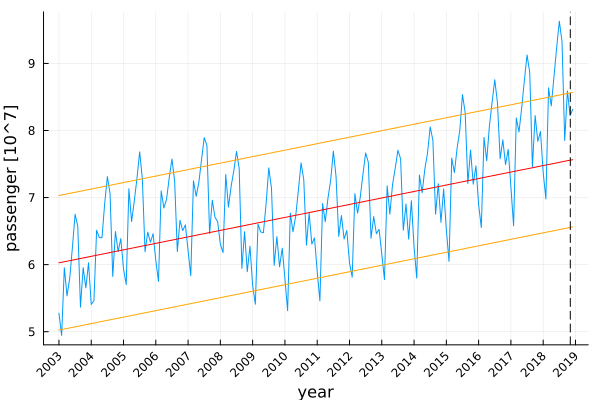

In [17]:
_, map_vector = get_map(res_3_1)
plot_trend_model_3_1(air_passengers_2013_2018, map_vector)

### Debugging a Probabilistic Program

The first approach to debugging inference of a probabilistic program is to look at the MCMC diagnostic plots.

They show how the values of the latent variables are explored during inference.

We can see that the values hardly change when using `MH` => bad exploration of the state space.

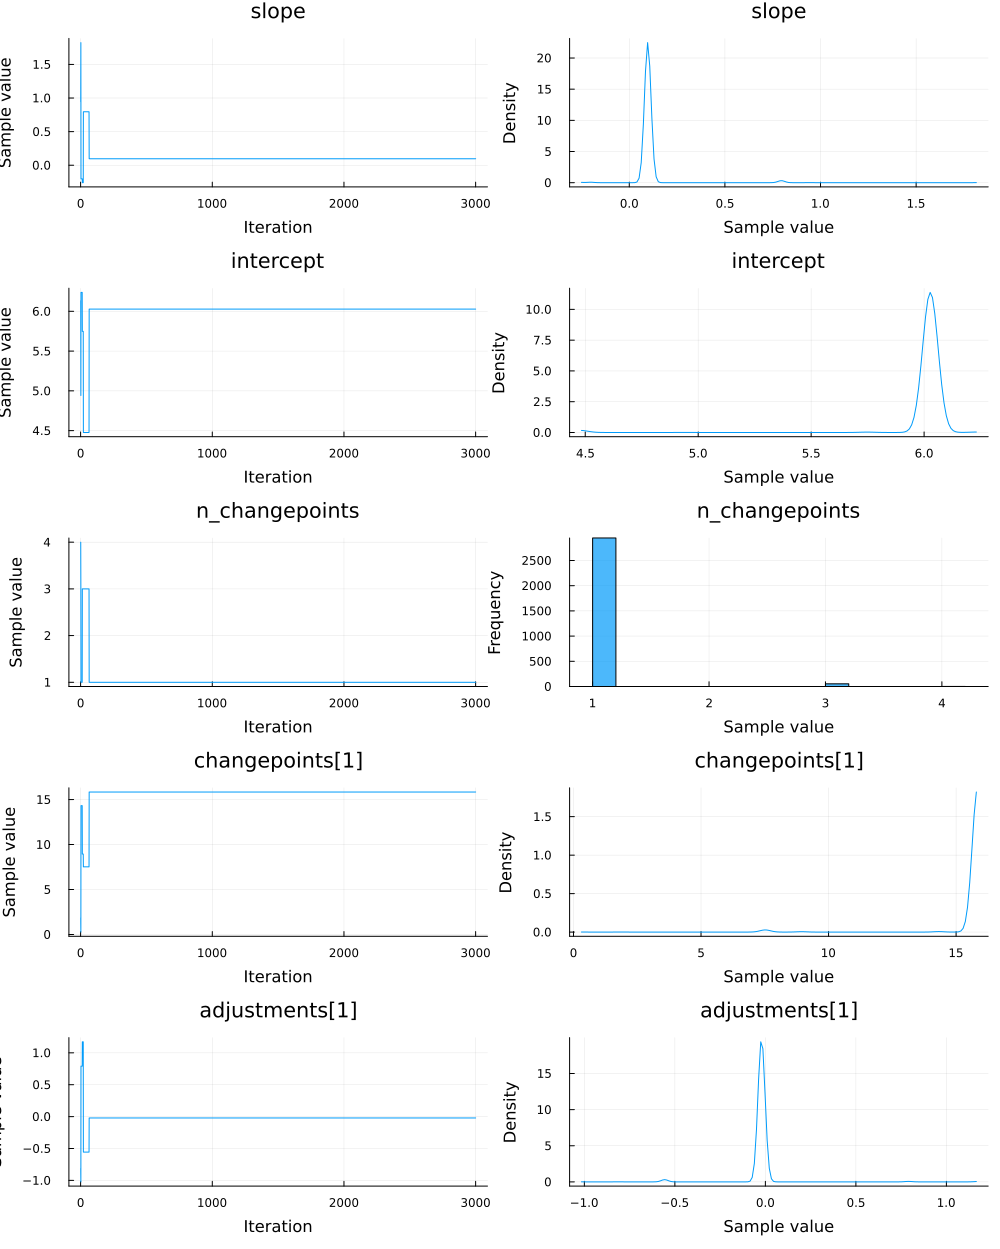

In [18]:
plot(res_3_1[["slope", "intercept", "n_changepoints", "changepoints[1]", "adjustments[1]"]])

For reference, below you can see how MCMC diagnostic plots are supposed to look if the inference algorithm explores the state space well.

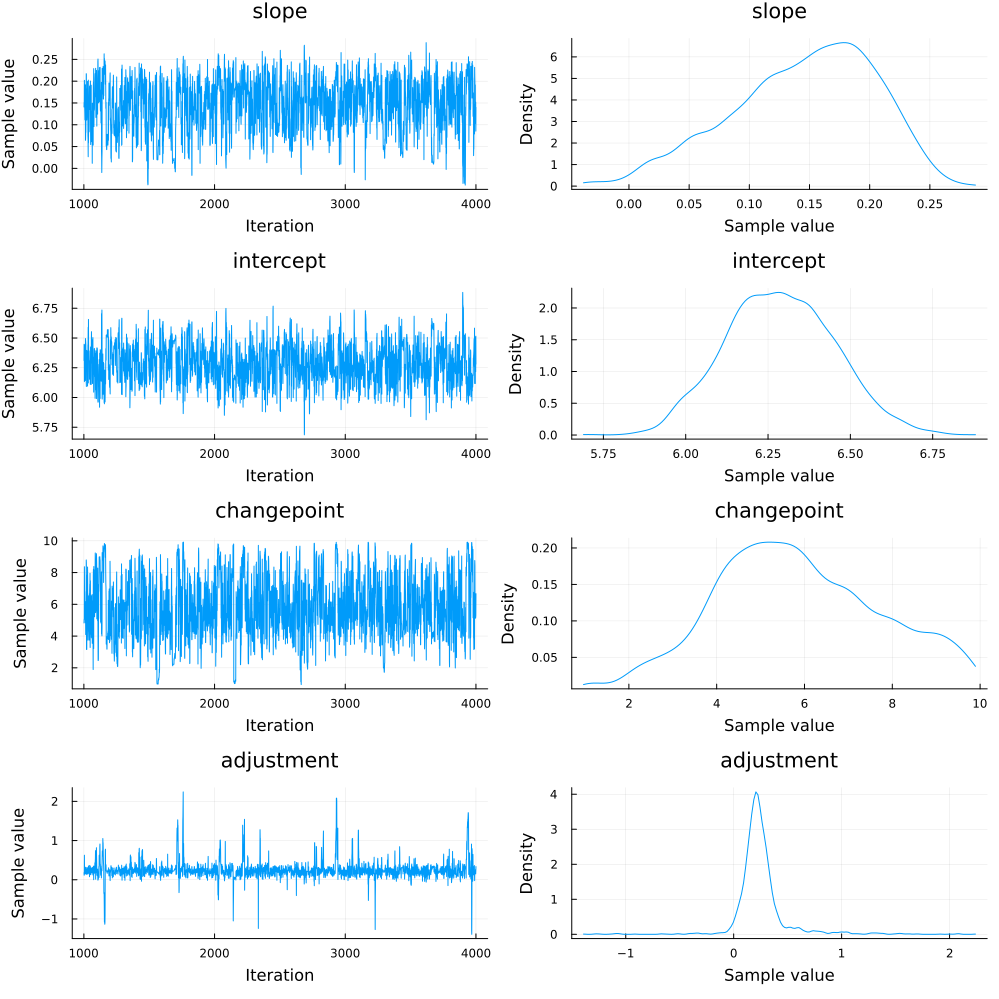

In [19]:
plot(single_chainpoint_res[["slope", "intercept", "changepoint", "adjustment"]])

There are two reasons why the inference may fail like in our case:
- the model does not describe the data well
- the inference algorithm is not able to compute the correct posterior

We can test for the first reason by inspecting the "worlds" our model can generate - this is called a **Prior Predictive Check**.

To test for the second reason, we try our inference algorithm on simulated data, because then we know that the model perfectly describes the data - this is called **Fake Data Simulation**.

#### Prior Predictive Check

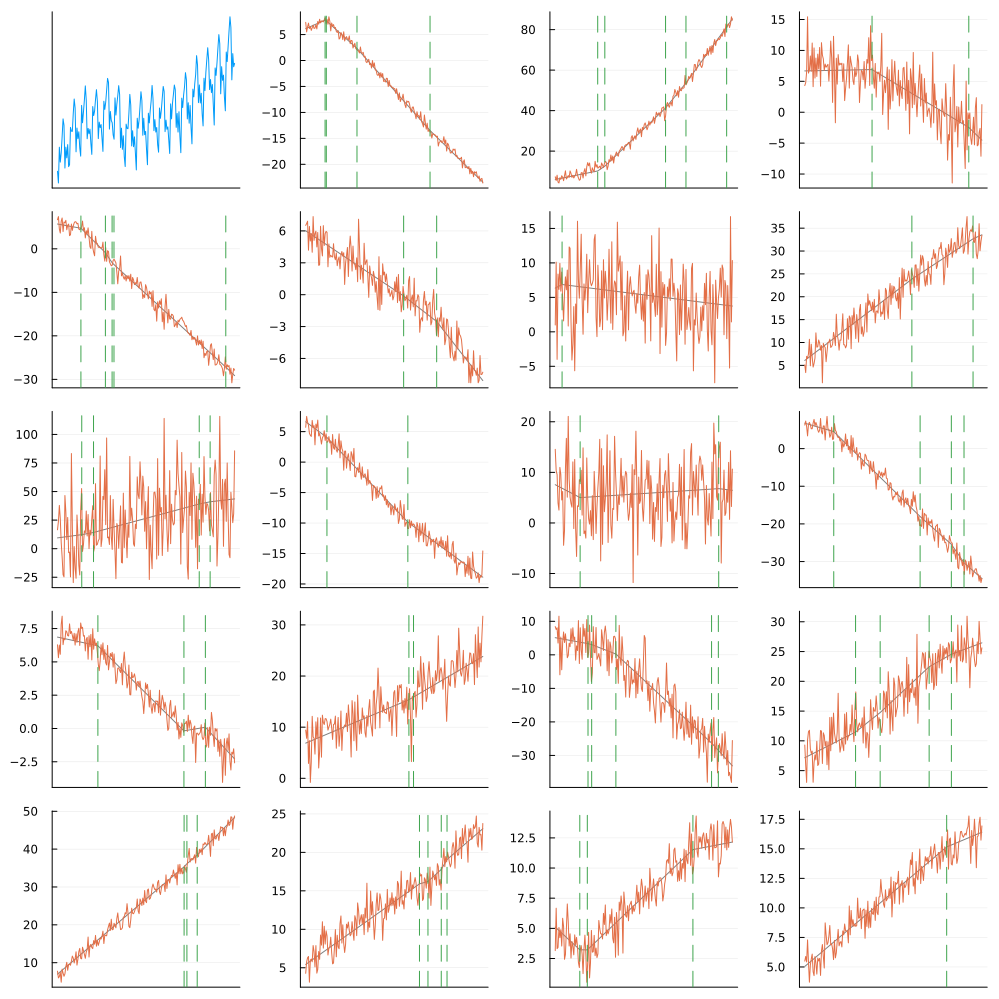

In [20]:
Turing.Random.seed!(0)
x = air_passengers_2013_2018[!,"Date"]

# use probalistic program as a generative model
res_prior = sample(trend_model_3_1(x, missing), Prior(), 19, progress=false)

t_min = x[1]
t_max = x[end]

p = plot(x, air_passengers_2013_2018[!,"Total"], legend=false, xticks=[], yticks=[])
ps = [p]
for i in 1:length(res_prior)
    _, trace = get_trace(res_prior,i)
    slope, intercept = trace[1:2]
    n_changepoints = Int(trace[4])
    changepoints = trace[5:9][1:n_changepoints]
    adjustments = trace[10:14][1:n_changepoints]
    y_from_prior = trace[15:end]
    p = plot(x, t -> trend_model_3_1_f(t - t_min, slope, intercept, changepoints, adjustments), color=:gray, legend=false, xticks=[])#, yticks=[])
    plot!(p, x, y_from_prior)
    
    cps = changepoints .+ t_min
    vline!(p, cps[(t_min .< cps) .& (cps .< t_max)], linestyle=:dash)
    push!(ps, p)
end
plot(ps..., layout=(5,4), size=(1000,1000))

The generated "worlds" seem to agree with our intention for modelling changepoints. 

#### Fake-Data Simulation

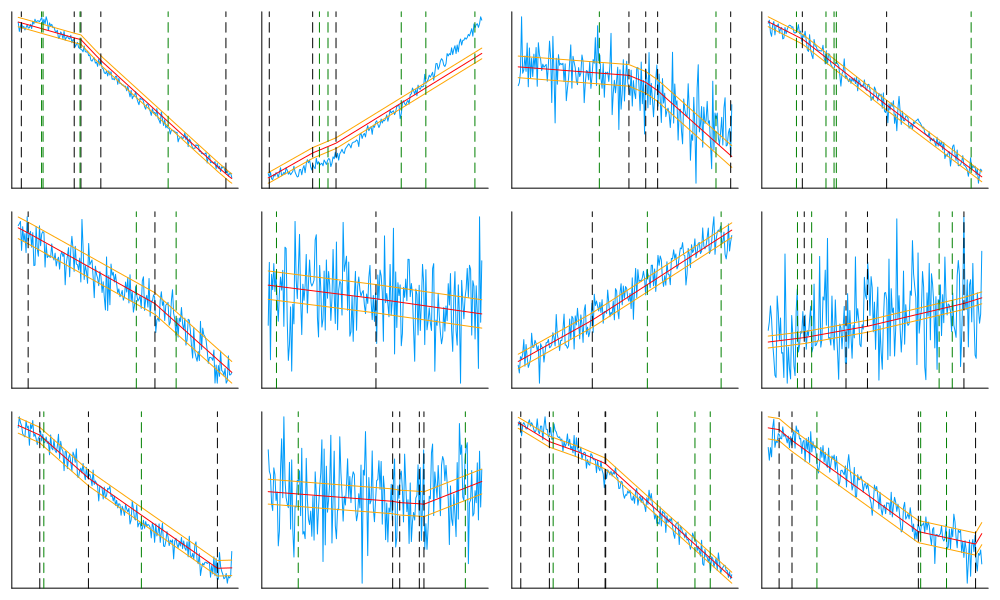

In [21]:
ps = []
for i in 1:12
    # for each of the simulated data sets ...
    _, trace = get_trace(res_prior,i)
    slope, intercept = trace[1:2]
    n_changepoints = Int(trace[4])
    true_changepoints = trace[5:9][1:n_changepoints]
    # adjustments = trace[10:14][1:n_changepoints]
    y_from_prior = trace[15:end]

    # ... perform posterior inference ...
    Turing.Random.seed!(10)
    ppc_res = sample(trend_model_3_1(x, y_from_prior), sampler_3_1, 3000, progress=false)

    # ... and check if we can recover the true latents
    _, map_vector = get_map(ppc_res)
    p = plot_trend_model_3_1((x, y_from_prior), map_vector)
    vline!(true_changepoints .+ t_min, linestyle=:dash, color=:green)
    plot!(p, xticks=[], yticks=[], xlabel="", ylabel="")
    
    push!(ps,p)
end
plot(ps..., layout=(3,4), size=(1000,600))

We conclude that the model should be able to describe our data, however, the inference algorithm is not powerful enough.

#### Multiple Changepoints - Second Try

Instead of trying to engineer a powerful inference algorithm, we adjust the model slightly to work with `NUTS` again.

The problem was that the number of true changepoints is discrete and unknown.

We now fix the changepoints at the beginning of each year, but put a restrictive prior on the adjustments,  
such that the adjustments tend to 0 if there is no real change in trend.

In [22]:
@model function trend_model_3(x::Vector{Float64}, y::Vector{Float64})
    slope ~ Normal(0,3)
    intercept ~ Normal(6,3)
    error ~ InverseGamma(2,3)
    tau ~ InverseGamma(1,1)

    # UPGRADE: fix one changepoint per year, put restrictive Laplace prior on adjustments
    n_changepoints = Int(ceil(length(y) / 12)) # changepoint at each year
    adjustments ~ filldist(Laplace(0,tau+1e-5), n_changepoints)
    
    k = slope
    m = intercept
    j = 1
    for i in eachindex(y)
        # UPGRADE: adjust slope and intercept at beginning of each year
        if i % 12 == 1
            k += adjustments[j]
            m -= (x[i] - x[1]) * adjustments[j]
            j += 1
        end
        y[i] ~ Normal(k * (x[i] - x[1]) + m, error+1e-5)
    end
end

trend_model_3 (generic function with 2 methods)

In [23]:
Turing.Random.seed!(0)
res_3 = sample(trend_model_3(air_passengers_2013_2018[!,"Date"], air_passengers_2013_2018[!,"Total"]), NUTS(), 3000, progress=PRINT_PROGRESS);

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:05


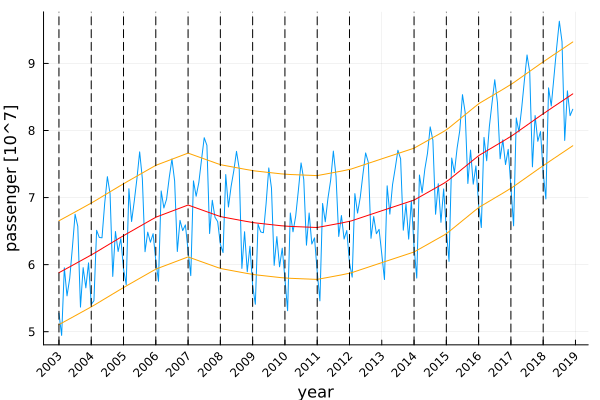

In [24]:
 _, map_vector = get_map(res_3)
plot_trend_model_3(air_passengers_2013_2018, map_vector)

For even faster model iteration, we may solve directly for the MAP which is faster.

In [25]:
res_3 = optimize(trend_model_3(air_passengers_2013_2018[!,"Date"], air_passengers_2013_2018[!,"Total"]), MAP(), Optim.Options(iterations=10_000))

ModeResult with maximized lp of -164.95
[0.2655989336155957, 5.906068720652697, 0.6010083643794552, 0.09199541345535943, 1.8418016686544358e-16, -8.674005781442314e-19, -0.025599904909581975, -0.17889816214404183, -0.09276116993976487, -1.6887703644995532e-16, 1.2691970748013106e-16, 0.030928720902240785, 0.0728998793853017, 0.00040850074223432214, 0.15623752939822977, 0.07632014734989245, 0.0022329676939029197, 2.7895405634532633e-15, 3.987759792310499e-17, -9.32115997167157e-19]

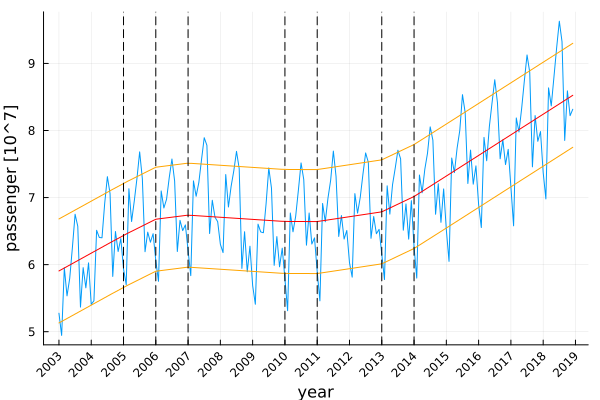

In [26]:
map_vector = res_3.values.array
plot_trend_model_3(air_passengers_2013_2018, map_vector)

Now we are happy with the trend model.

### Seasonality

So far we have completely neglected the seasonality of the time series.

But having modelled the trend of the time series accurately, we can substract the trend from the data and solely focus on the seasonality.

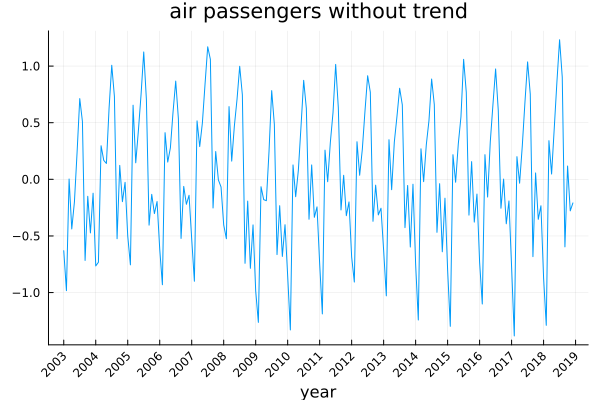

In [27]:
x = air_passengers_2013_2018[!,"Date"]
y = air_passengers_2013_2018[!,"Total"]
t_min = x[1]
changepoints = x[(1:length(x)) .% 12 .== 1] .- x[1]
slope, intercept, error, adjustments = map_vector[1], map_vector[2], map_vector[3], map_vector[5:end]

# substract the trend model from the data
y_stationary =  y .- map(t -> trend_model_3_f(t - t_min, slope, intercept, changepoints, adjustments), x)

base_plot((x, y_stationary))
title!("air passengers without trend")
ylabel!("")

Seasonality is modelled by decomposing the time series into sinusoidal functions with different frequencies and phase shifts.

In [28]:
function seasonality_component(t::Float64, N_frequencies::Int, beta::Vector{<:Real})
    s = 0
    for n in 1:N_frequencies
        s += beta[2*n-1] * sin(2*pi*n*t)
        s += beta[2*n] * cos(2*pi*n*t)
    end
    return s
end

@model function seasonality_model(x::Vector{Float64}, y::Vector{Float64}, N_frequencies::Int)
    beta ~ filldist(Normal(0,1.), 2*N_frequencies)
    error ~ InverseGamma(2,3)
    
    for i in eachindex(y)
        t = x[i] - x[1]
        s = seasonality_component(t, N_frequencies, beta)
        y[i] ~ Normal(s, error+1e-5)
    end

end

seasonality_model (generic function with 2 methods)

Try out different number of frequencies.

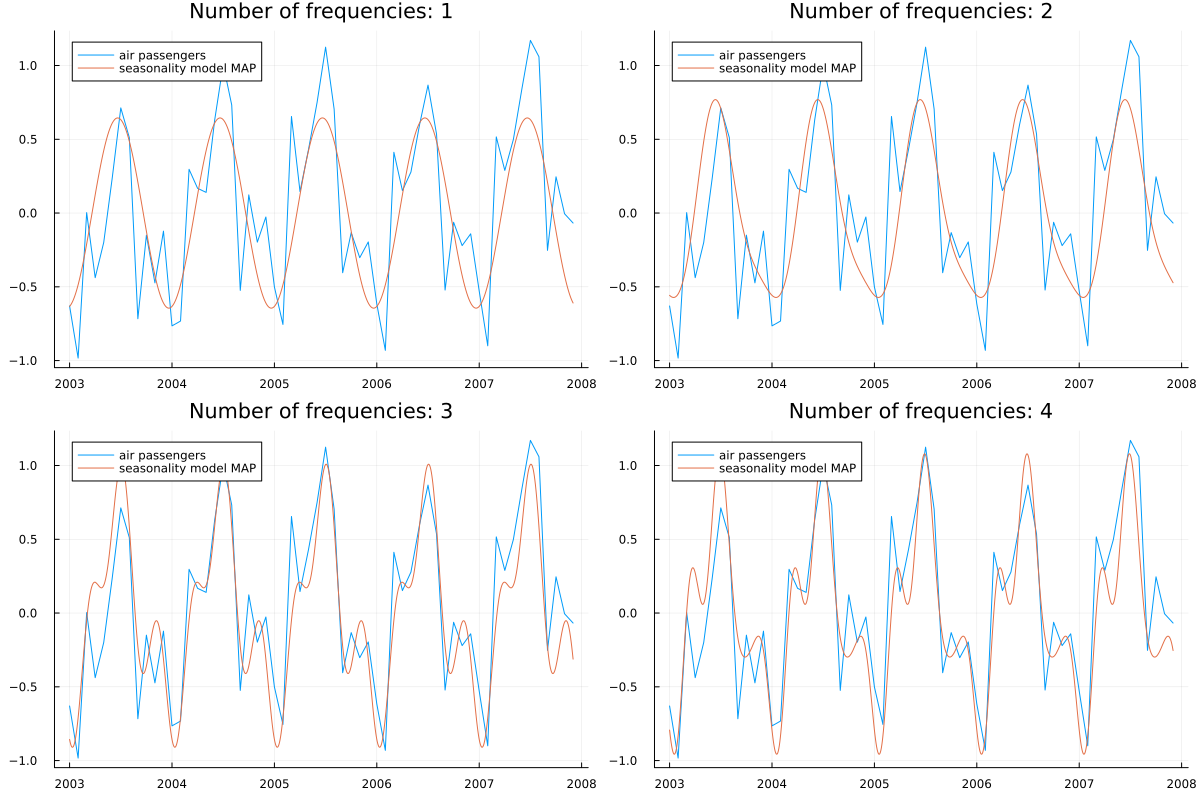

In [29]:
ps = []
for N_frequencies in 1:4
    res_seasonal = optimize(seasonality_model(x, y_stationary, N_frequencies), MAP())
    beta = res_seasonal.values.array

    mask = 1:60
    p = plot(x[mask], y_stationary[mask], label="air passengers", legend=:topleft, title="Number of frequencies: $N_frequencies")
    plot!(t -> seasonality_component(t, N_frequencies, beta), label="seasonality model MAP")
    push!(ps, p)
end
plot(ps...,layout=(2,2), size=(1200,800))

In [30]:
N_frequencies = 3 # seems to be a good choice

3

#### Combining the Trend and Seasonality Components

Simply combine trend and seasonality models.

In [31]:
@model function prophet(x::Vector{Float64}, y::Vector{Float64}, N_frequencies::Int)
    slope ~ Normal(0,3)
    intercept ~ Normal(6,3)
    error ~ InverseGamma(2,3)
    n_changepoints = Int(ceil(length(y) / 12)) # changepoint at each year
    tau ~ InverseGamma(1,1)
    adjustments ~ filldist(Laplace(0,tau+1e-5), n_changepoints)
    beta ~ filldist(Normal(0,1.), 2*N_frequencies)

    k = slope
    m = intercept
    j = 1
    for i in eachindex(y)
        t = (x[i] - x[1])
        if i % 12 == 1
            k += adjustments[j]
            m -= t * adjustments[j]
            j += 1
        end
        s = seasonality_component(t, N_frequencies, beta)

        y[i] ~ Normal(k * t + m + s, error+1e-5)
    end
end

prophet (generic function with 2 methods)

Solve for the MAP.

In [32]:
N_frequencies = 3
x = air_passengers_2013_2018[!,"Date"]
y = air_passengers_2013_2018[!,"Total"]
changepoints = x[(1:length(x)) .% 12 .== 1] .- x[1]

Turing.Random.seed!(1)
map_estimate = optimize(prophet(x, y, N_frequencies), MAP(), Optim.Options(iterations=10000))

ModeResult with maximized lp of -23.59
[0.4577668853959833, 5.676798414159017, 0.26486973435303784, 0.15564037214657933, -1.8024725766680047e-16, -3.524588295884899e-17, -0.33308075971101825, -1.3193756999074557e-10, -0.013055172774100565, -0.599594466878374  …  3.00675322887742e-6, 3.2354536360592883e-18, 0.0027787046763455446, 6.748800756489422e-16, 0.12903737468239745, -0.6323295364796718, -0.11315127980651665, 0.07650192846864177, -0.15896492058501327, -0.29719464597431666]

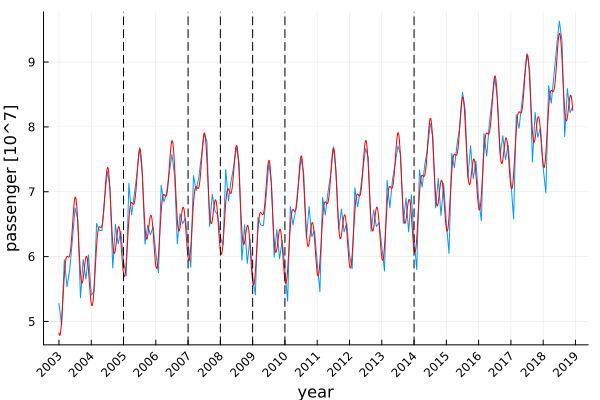

In [33]:
map_vector = map_estimate.values.array
n_changepoints = length(y) ÷ 12

slope, intercept, error, tau,  adjustments = map_vector[1:4]..., map_vector[5:(5+n_changepoints-1)]
beta = map_vector[5+n_changepoints : end]

plot_prophet_model(air_passengers_2013_2018, map_vector, N_frequencies, n_changepoints)

We can be quite happy with the fit of the model.

We now sample the posterior and use the map as initial point.

In [34]:
Turing.Random.seed!(0)
res_prophet = sample(prophet(x, y, N_frequencies), NUTS(), 1000, progress=PRINT_PROGRESS, init_params=map_estimate.values.array);

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:58


### Using the resulting posterior

Let $X$ be the data and $T$ some quantity of interest.

We can find the *posterior predictive distribution* over $T$ by "averaging over the posterior":

$p (T | X) = \int p(T | \theta, X) p(\theta | X) d\theta$

For instance, $T$ = how large is the difference between January and August passengers?

"Averaging over the posterior" is simply looking at the histogram.

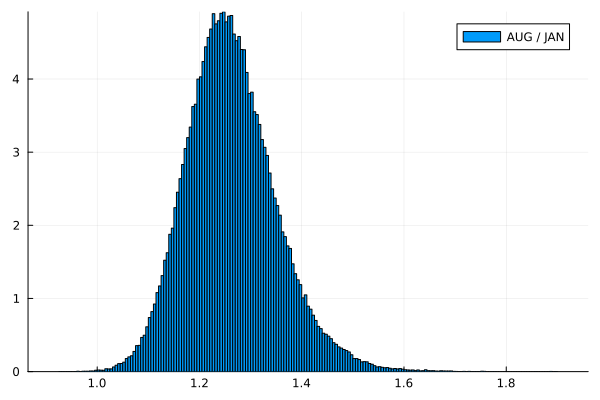

In [35]:
T = Float64[]

n_years = length(y) ÷ 12
n_samples_per_trace = 10

# iterate over posterior
for i in 1:length(res_prophet)
    trace = res_prophet[i].value.data

    slope, intercept, error, tau,  adjustments = trace[1:4]..., trace[5:(5+n_changepoints-1)]
    beta = trace[5+n_changepoints : end]

    # produce samples for T | θ, X
    for year in 0:(n_years-1)
        jan_mean = prophet_model_f(x[year * 12 + 1] - x[1], slope, intercept, changepoints, adjustments, N_frequencies, beta)
        aug_mean = prophet_model_f(x[year * 12 + 8] - x[1], slope, intercept, changepoints, adjustments, N_frequencies, beta)
        
        for _ in 1:n_samples_per_trace
            jan = rand(Normal(jan_mean, error))
            aug = rand(Normal(aug_mean, error))
            push!(T, aug / jan)
        end
    end
end
histogram(T, normalize=true, label="AUG / JAN")

### Forecasting

Of course, we are also interested in forecasting the time series.

To get accurate uncertainty quantification, we go back to our full Bayesian approach:   
We approximate the full posterior instead of only optimising for the MAP.

However, it is a good idea to set the MAP as starting point for the inference process.

Next, we extrapolate into the future by continuing the trend, respecting the seasonality and randomly sampling future changepoints.

In [36]:
function prophet_forecast(x::Vector{Float64}, y::Vector{Float64},
    m::Float64, k::Float64, error::Float64, N_frequencies::Int, beta::Vector{Float64}, adjustments::Vector{Float64},
    forecast::Int)

    tau = mean(abs, adjustments)

    n_future_changepoints = ((length(y) + forecast) ÷ 12) - (length(y) ÷ 12)
    future_adjustments = rand(filldist(Laplace(0,tau), n_future_changepoints))

    y_pred = zeros(forecast)
    Δ = x[2] - x[1]
    x_future = x[end]
    i = length(y)+1
    j = 1
    while i <= length(y) + forecast
        x_future += Δ
        t = (x_future - x[1])

        if i % 12 == 1
            k += future_adjustments[j]
            m -= t * future_adjustments[j]
            j += 1
        end

        s = seasonality_component(t, N_frequencies, beta)
        y_pred[i-length(y)] = rand(Normal(k * t + m + s, error))
        i += 1
    end

    return y_pred
end

prophet_forecast (generic function with 1 method)

We write a helper function to extrapolate randomly `n_samples_per_trace` times for each sample in the posterior.

In [37]:
function sample_forecast(res, changepoints, forecast, n_samples_per_trace)
    n_changepoints = length(changepoints)
    y_pred = zeros(n_samples_per_trace * length(res), forecast)

    j = 0
    for i in 1:length(res)
        trace = reshape(res[i].value.data, :)

        slope, intercept, error, tau,  adjustments = trace[1:4]..., trace[5:(5+n_changepoints-1)]
        beta = trace[5+n_changepoints : end]

        for _ in 1:n_samples_per_trace
            j += 1
            k = slope + sum(adjustments)
            m = intercept - adjustments'changepoints
            y_pred[j,:] = prophet_forecast(x,y,m,k,error,N_frequencies,beta,adjustments,forecast)
        end
    end
    return y_pred
end

sample_forecast (generic function with 1 method)

Again, with plotting the forecast, we can check if we are satisfied with the results.

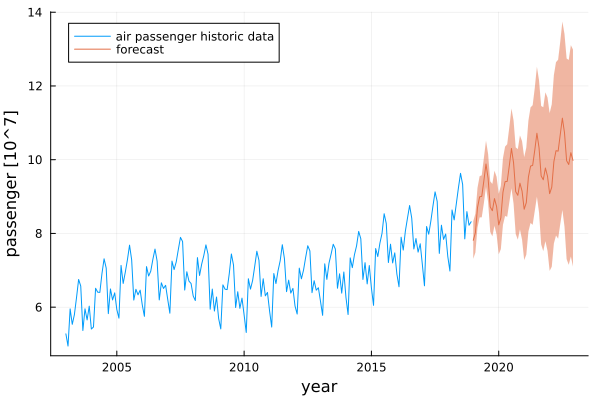

In [38]:
n_year_forecast = 4
forecast = n_year_forecast * 12
x_forecast = collect(maximum(x) .+ (1:forecast)./12)

y_pred = sample_forecast(res_prophet, changepoints, forecast, 10)
plot_forecast(x, y, x_forecast, y_pred)

### How to model the pandemic ?

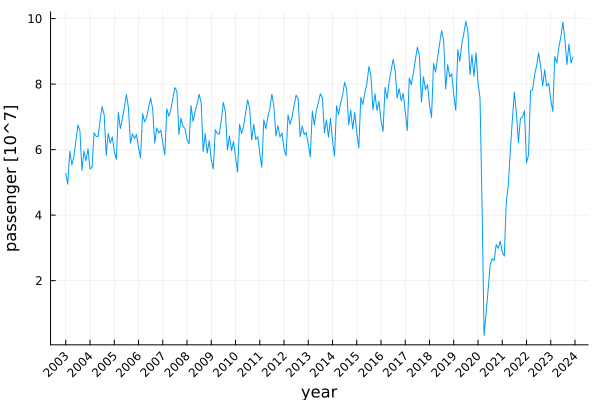

In [39]:
base_plot(air_passengers_2013_2023)

What happens if we apply the unmodified model?

In [40]:
N_frequencies = 3
x = air_passengers_2013_2023[!,"Date"]
y = air_passengers_2013_2023[!,"Total"]
changepoints = x[(1:length(x)) .% 12 .== 1] .- x[1];

In [41]:
Turing.Random.seed!(0)
map_estimate = optimize(prophet(x, y, N_frequencies), MAP(), Optim.Options(iterations=10000))

Turing.Random.seed!(0)
res_prophet_2023 = sample(prophet(x, y, N_frequencies), NUTS(), 1000, progress=PRINT_PROGRESS, init_params=map_estimate.values.array);

┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling: 100%|█████████████████████████████████████████| Time: 0:02:35


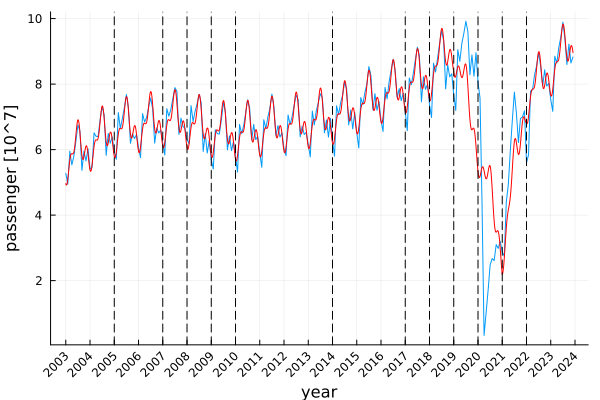

In [42]:
map_vector = map_estimate.values.array
n_changepoints = length(changepoints)

plot_prophet_model(air_passengers_2013_2023, map_vector, N_frequencies, n_changepoints)

Thanks to our fully Bayesian approach, the uncertainty around our prediction is know very large,  
reflecting the fact that the model does not fit the data well anymore.

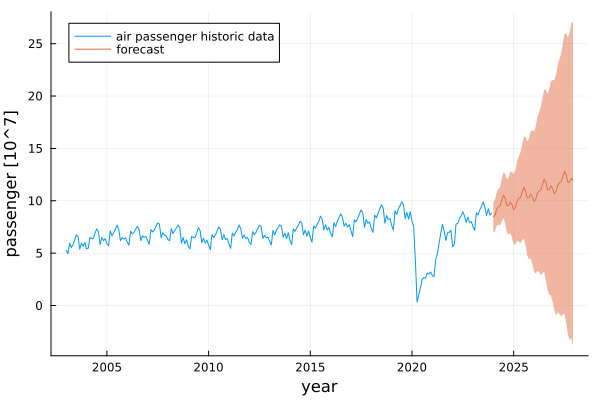

In [43]:
n_year_forecast = 4
forecast = n_year_forecast * 12
x_forecast = collect(maximum(x) .+ (1:forecast)./12)

y_pred = sample_forecast(res_prophet_2023, changepoints, forecast, 10)
plot_forecast(x, y, x_forecast, y_pred)

By modelling the pandemic explicitly, we would introduce additional information in the model and could reduce the forecast uncertainty.

How to achieve this is beyond the scope of this notebook.